In [37]:
!pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 18.3 MB/s eta 0:00:00


# Our goal: predict a property (bandgap) of an organic molecule

In [9]:
# Import Libraries:
import pandas as pd
import pycaret.regression as reg
import numpy as np
import rdkit
import matplotlib.pyplot as plt
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import rdMolDescriptors as d1
from rdkit.Chem import Descriptors as d2
from rdkit.Chem import AllChem
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load

In [10]:
organic_training_set = 'https://raw.githubusercontent.com/singhk28/a3md_bc4/main/datasets/training_set_organics.csv'

In [11]:
# Load Data:

df = pd.read_csv(organic_training_set)

# Look @ top 5 rows:
df.head()

,smiles,bandgap,formulas
0,CSc1cccc(C(=O)c2ccc(-n3c4ccc(C)cc4c4cc(-c5c(C)...,3.0819,C37H33NOS
1,CN(C)c1ccc(Oc2cnc3oc4ncccc4c3c2)cc1,3.2434,C18H15N3O2
2,Cc1cc(-c2cc(C(F)(F)F)c(C(F)(F)F)cc2-c2cc(C)c(-...,3.0379,C44H30F6N2O2
3,Cc1cc(-c2cccc(C(=O)C(F)(F)F)c2)ccc1-c1ccc(-n2c...,2.1996,C57H40F3N3O
4,CSc1cc(C(=O)c2cc(C)cc(C)c2)cc(-c2c(C)c(C)c(-c3...,3.5064,C40H39NOS2


# Data cleaning & Splitting

In [12]:
# Remove missing data columns:
df = df.dropna()

# Split Data into training and test set:
df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)

# Create Transformation Pipeline

In [13]:
# Create a function to convert Smiles to RDKIT and then check for errors:
def smiles_to_mol_qa(df: pd.core.frame.DataFrame = None,
                     smiles_col: str = 'smiles',
                     mol_obj_col: str = 'mol_objs',
                     formula_col: str = 'formulas',
                     formula_mol_col: str = 'formula_from_mol_obj') -> pd.core.frame.DataFrame:


    if df is not None:
        df2 = df.copy()

        #Convert smiles to Mol objects:
        df2[mol_obj_col] = df2[smiles_col].apply(lambda smile_string: rdkit.Chem.MolFromSmiles(smile_string))
        df2.dropna(inplace=True)
        df2.reset_index(drop=True)

        #Check mol objects for Errors:
        df2[formula_mol_col] = [CalcMolFormula(mol_obj)for mol_obj in df2[mol_obj_col]]
        df2 = df2.drop(df2[df2[formula_col]!= df2[formula_mol_col]].index).reset_index(drop=True)


        return df2

    else:
        print('Please provide DataFranme variable name')

In [14]:
# Create a function for featurization:
def small_mol_featurizer(df: pd.core.frame.DataFrame = None,
                         mol_obj_col: str = 'mol_objs',
                         featurizer_dict: dict = {'mol_wt':d1.CalcExactMolWt,
                                                  'Num_Rings':d1.CalcNumRings,
                                                  'Aromatic_rings':d1.CalcNumAromaticRings,
                                                  'HBA': d1.CalcNumHBA,
                                                  'HBD': d1.CalcNumHBD,
                                                  'C_SP3_Hybrid': d1.CalcFractionCSP3,
                                                  'Num_heavy_atoms': d1.CalcNumHeavyAtoms,
                                                  'Valence_electrons': d2.NumValenceElectrons}) -> pd.core.frame.DataFrame:

    if df is not None:
        df_with_features = df.copy()

        for feature in featurizer_dict:
            df_with_features[feature] = df_with_features[mol_obj_col].apply(lambda mol_obj: featurizer_dict[feature](mol_obj))

        return df_with_features, featurizer_dict


    else:
        print('Please provide DataFranme variable name')

In [15]:
# Create a function for structural fingerprint/featurization:
def morgan_fp(df: pd.core.frame.DataFrame = None,
              mol_obj_col: str = 'mol_objs',
              num_cir: int = 2,
              fp_size: int = 512) -> pd.core.frame.DataFrame:

    fp_df_list = []

    if df is not None:
        df2 = df.copy()

        for mol_obj in df2[mol_obj_col]:
            morg_fp = AllChem.GetMorganFingerprintAsBitVect(mol_obj, num_cir, fp_size)
            morg_fp_string = morg_fp.ToBitString()
            morg_fp_arr = np.fromiter(morg_fp_string, dtype='int')
            fp_df = pd.DataFrame(morg_fp_arr).T
            fp_df_list.append(fp_df)

    fp_df = pd.concat(fp_df_list).reset_index(drop=True)

    return pd.concat([df2, fp_df], axis=1)

In [16]:
# Create a function to normalize data
def normalize_data(df: pd.core.frame.DataFrame = None,
                   mode: str = 'create',
                   cols_to_norm: list = None,
                   scaler_filename: str = 'scaler_org.pkl'):

    if df is not None:

        if mode == 'create':
            if cols_to_norm is not None:
                # Initialize scaler:
                scaler = MinMaxScaler()

                # Fit the Scaler to Data:
                fitted_scaler = scaler.fit(df[cols_to_norm])

                # Saving our fitted Scaler for later use:
                dump(fitted_scaler, open(scaler_filename, 'wb'))

                # Transform the data using the fitted scaler:
                df[cols_to_norm] = fitted_scaler.transform(df[cols_to_norm])

                return df

        if mode == 'use':
            if cols_to_norm is not None:
                loaded_scaler = load(open(scaler_filename, 'rb'))
                df[cols_to_norm] = loaded_scaler.transform(df[cols_to_norm])

                return df

In [17]:
# Create a function to normalize data
def clean_up(df: pd.core.frame.DataFrame = None,
             cols_to_drop: list = ['smiles', 'mol_objs','formulas', 'formula_from_mol_obj']) -> pd.core.frame.DataFrame:

    df = df.drop(cols_to_drop, axis=1)
    return df

In [18]:
def transformation_pipeline(df: pd.core.frame.DataFrame = None,
                            normalizer_mode: str = None)-> pd.core.frame.DataFrame:


    if df is not None:

        # Create a Copy of Df
        df2 = df.copy()

        # Convert Smiles to Mol Objects and Remove those with Errors
        df2 = smiles_to_mol_qa(df2)

        # Featurize the structures:
        df2, featurizer_dict = small_mol_featurizer(df2)
        df2 = morgan_fp(df2)

        # Normalize Data:
        if normalizer_mode is not None:
            df2 = normalize_data(df2, normalizer_mode, list(featurizer_dict.keys()))

        df2 = clean_up(df2)

        return df2

    else:
        print('Please provide Df to transform')

# Apply Transformation Pipeline to Datasets

In [19]:
df_train.head()

,smiles,bandgap,formulas
4061,O=C1C=CC(=O)N1c1ccc2c(c1)Oc1cc(N3C(=O)C=CC3=O)...,1.6178,C50H29N5O6
20101,COc1cc(C(=O)c2c(C)c(C)cc(C)c2C)cc(N(c2ccccc2)c...,3.0039,C31H31NO2
12483,Cc1cc(-c2ccc3ncncc3c2)cc(C)c1-c1cc(-c2c(C)cc(-...,2.6017,C74H55N7
12197,Cc1c(-c2cc(-c3cc(F)c(F)c(F)c3)cc(-c3cc(F)c(F)c...,3.6973,C34H19F6NO
15237,O=C1c2ccccc2C(=O)N1c1ccc2c(n1)sc1nc(-n3cnc4cc5...,3.0705,C44H20N10O4S2


In [20]:
df_train_transformed = transformation_pipeline(df_train, 'create') # create for the normalization mode
df_train_transformed

[12:08:32] SMILES Parse Error: extra close parentheses while parsing: COc1ccc2c(c1)c1ccccc1n2-c1ccc-c3ccccc3)nc(-c3ccccc3)n2)c1
[12:08:32] SMILES Parse Error: Failed parsing SMILES 'COc1ccc2c(c1)c1ccccc1n2-c1ccc-c3ccccc3)nc(-c3ccccc3)n2)c1' for input: 'COc1ccc2c(c1)c1ccccc1n2-c1ccc-c3ccccc3)nc(-c3ccccc3)n2)c1'
[12:08:35] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)cc(-c2cncc(-c3cc(-c4cncc(-c5cc(C)cc(C)c5)n4)cc(-nc5cnccc54)c3)n2)c1'
[12:08:40] SMILES Parse Error: syntax error while parsing: C/(C=N)=C(/C)C=N
[12:08:40] SMILES Parse Error: Failed parsing SMILES 'C/(C=N)=C(/C)C=N' for input: 'C/(C=N)=C(/C)C=N'
[12:08:42] SMILES Parse Error: extra open parentheses for input: 'Cc1c(C)c(-c2nncc3cccnc23)c(C)c(C)c1-c1cc(Ncc(N2c3ccccc3Oc3ccccc32)c1'


,bandgap,mol_wt,Num_Rings,Aromatic_rings,HBA,HBD,C_SP3_Hybrid,Num_heavy_atoms,Valence_electrons,0,...,502,503,504,505,506,507,508,509,510,511
0,1.6178,0.481798,0.521739,0.347826,0.264706,0.0,0.000000,0.495413,0.479245,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0039,0.244062,0.173913,0.173913,0.088235,0.0,0.193548,0.247706,0.256604,1,...,0,0,0,0,0,0,0,0,0,0
2,2.6017,0.651001,0.608696,0.608696,0.205882,0.0,0.054054,0.678899,0.660377,0,...,0,0,0,0,0,0,0,0,0,1
3,3.6973,0.327826,0.260870,0.260870,0.058824,0.0,0.029412,0.321101,0.324528,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0705,0.496159,0.565217,0.478261,0.411765,0.0,0.000000,0.486239,0.464151,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19982,3.3945,0.299686,0.304348,0.304348,0.205882,0.0,0.000000,0.311927,0.298113,0,...,0,0,0,0,0,0,0,0,0,1
19983,3.3605,0.378063,0.391304,0.391304,0.117647,0.0,0.043478,0.394495,0.381132,1,...,0,0,0,0,0,0,0,0,0,1
19984,2.5936,0.651767,0.739130,0.391304,0.176471,0.0,0.324324,0.669725,0.679245,0,...,0,0,0,0,0,0,0,0,0,1
19985,2.8950,0.325105,0.304348,0.260870,0.117647,0.0,0.025641,0.330275,0.313208,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
df_test_transformed = transformation_pipeline(df_test, 'use') # use normalization parameters learned on the train set
df_test_transformed

,bandgap,mol_wt,Num_Rings,Aromatic_rings,HBA,HBD,C_SP3_Hybrid,Num_heavy_atoms,Valence_electrons,0,...,502,503,504,505,506,507,508,509,510,511
0,3.0415,0.283933,0.173913,0.173913,0.088235,0.00,0.264706,0.275229,0.290566,0,...,0,0,0,0,0,0,0,0,0,0
1,3.3258,0.490860,0.521739,0.434783,0.235294,0.00,0.222222,0.504587,0.505660,0,...,0,0,0,0,0,1,0,0,0,0
2,2.7179,0.596769,0.391304,0.391304,0.117647,0.00,0.200000,0.614679,0.622642,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0387,0.508692,0.478261,0.391304,0.205882,0.00,0.107143,0.513761,0.509434,0,...,0,0,0,0,0,0,0,0,0,0
4,4.1795,0.309339,0.260870,0.217391,0.058824,0.00,0.157895,0.311927,0.305660,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,3.5689,0.481155,0.478261,0.478261,0.088235,0.00,0.000000,0.495413,0.471698,0,...,0,0,0,0,0,0,0,0,0,1
4993,3.1149,0.281870,0.260870,0.217391,0.058824,0.00,0.162162,0.293578,0.290566,0,...,0,0,0,0,0,1,0,0,0,0
4994,2.8267,0.536164,0.608696,0.565217,0.176471,0.00,0.064516,0.559633,0.539623,0,...,0,0,0,0,0,0,0,0,0,0
4995,3.0890,0.338254,0.217391,0.217391,0.147059,0.00,0.289474,0.330275,0.347170,0,...,0,0,0,0,0,0,0,0,0,0


# Apply autoML

You need to know more: go to the full tutorial on pycaret webpage: https://colab.research.google.com/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb#scrollTo=3198b571

In [22]:
# Initialize the Pycaret Pipeline:
reg_setup = reg.setup(data=df_train_transformed, test_data= df_test_transformed, target='bandgap', index=False) # set up a regression comparison with pycaret. Target: bandgap, features to use: the one extracted with rdkit.
best_algo = reg.compare_models(budget_time=2, sort="RMSE") # budget: run for max 2 minutes, # sort: measure to use to sort the trained models

,Description,Value
0,Session id,8875
1,Target,bandgap
2,Target type,Regression
3,Original data shape,"(24984, 521)"
4,Transformed data shape,"(24984, 521)"
5,Transformed train set shape,"(19987, 521)"
6,Transformed test set shape,"(4997, 521)"
7,Numeric features,520
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.1972,0.0689,0.2625,0.7699,0.0649,0.0653,0.3120
lr,Linear Regression,0.1972,0.0690,0.2626,0.7697,0.0650,0.0654,1.4330
br,Bayesian Ridge,0.1971,0.0690,0.2626,0.7696,0.0650,0.0654,1.3140
huber,Huber Regressor,0.2001,0.0756,0.2748,0.7478,0.0678,0.0663,10.9840
par,Passive Aggressive Regressor,0.2661,0.1165,0.3409,0.6107,0.0844,0.0871,0.8820
omp,Orthogonal Matching Pursuit,0.2577,0.1179,0.3432,0.6066,0.0864,0.0874,0.3790
lar,Least Angle Regression,0.2859,0.1673,0.3823,0.4518,0.0954,0.0940,0.5860
lasso,Lasso Regression,0.4307,0.3000,0.5476,-0.0005,0.1371,0.1490,0.2450
en,Elastic Net,0.4307,0.3000,0.5476,-0.0005,0.1371,0.1490,0.3530
llar,Lasso Least Angle Regression,0.4307,0.3000,0.5476,-0.0005,0.1371,0.1490,0.3070


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [23]:
best_mod = reg.tune_model(best_algo) # This function tunes the hyperparameters of a given estimator.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1979,0.0684,0.2615,0.7766,0.0658,0.0661
1,0.1980,0.0690,0.2626,0.7693,0.0648,0.0650
2,0.1946,0.0656,0.2562,0.7681,0.0635,0.0641
3,0.1993,0.0720,0.2683,0.7520,0.0678,0.0672
4,0.1994,0.0704,0.2653,0.7548,0.0646,0.0647
5,0.1961,0.0749,0.2737,0.7640,0.0649,0.0646
6,0.1970,0.0688,0.2623,0.7867,0.0653,0.0651
7,0.1975,0.0665,0.2578,0.7761,0.0646,0.0661
8,0.1959,0.0654,0.2557,0.7803,0.0638,0.0653


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


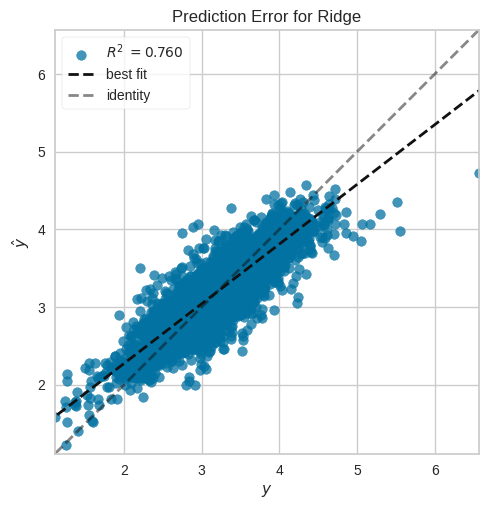

In [25]:
# plot error
reg.plot_model(best_mod, plot = 'error')

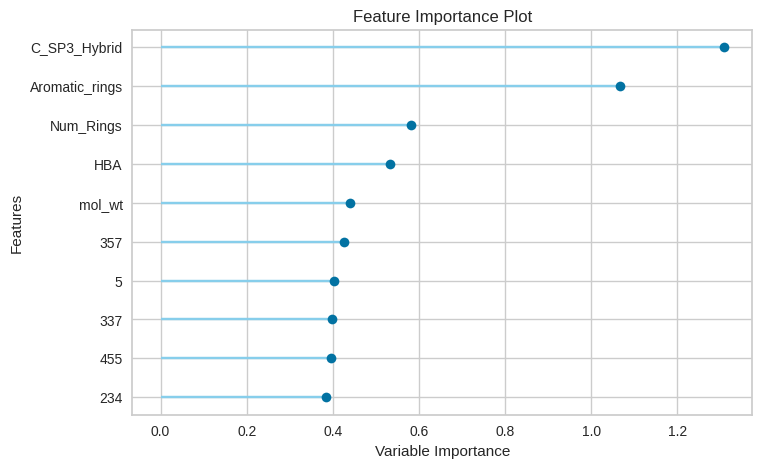

In [26]:
# plot feature importance
reg.plot_model(best_mod, plot = 'feature')

In [27]:
reg.predict_model(best_mod)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1974,0.0688,0.2622,0.7599,0.0637,0.0641


,mol_wt,Num_Rings,Aromatic_rings,HBA,HBD,C_SP3_Hybrid,Num_heavy_atoms,Valence_electrons,0,1,...,504,505,506,507,508,509,510,511,bandgap,prediction_label
19987,0.283933,0.173913,0.173913,0.088235,0.00,0.264706,0.275229,0.290566,0,0,...,0,0,0,0,0,0,0,0,3.0415,2.545058
19988,0.490860,0.521739,0.434783,0.235294,0.00,0.222222,0.504587,0.505660,0,0,...,0,0,0,1,0,0,0,0,3.3258,3.298040
19989,0.596769,0.391304,0.391304,0.117647,0.00,0.200000,0.614679,0.622642,0,0,...,0,0,0,0,0,0,0,0,2.7179,2.687449
19990,0.508692,0.478261,0.391304,0.205882,0.00,0.107143,0.513761,0.509434,0,0,...,0,0,0,0,0,0,0,0,3.0387,2.959466
19991,0.309339,0.260870,0.217391,0.058824,0.00,0.157895,0.311927,0.305660,0,0,...,0,0,0,1,0,0,0,0,4.1795,3.939988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,0.481155,0.478261,0.478261,0.088235,0.00,0.000000,0.495413,0.471698,0,1,...,0,0,0,0,0,0,0,1,3.5689,3.666513
24980,0.281870,0.260870,0.217391,0.058824,0.00,0.162162,0.293578,0.290566,0,0,...,0,0,0,1,0,0,0,0,3.1149,3.381434
24981,0.536164,0.608696,0.565217,0.176471,0.00,0.064516,0.559633,0.539623,0,1,...,0,0,0,0,0,0,0,0,2.8267,2.900769
24982,0.338254,0.217391,0.217391,0.147059,0.00,0.289474,0.330275,0.347170,0,0,...,0,0,0,0,0,0,0,0,3.0890,2.756591
